In [112]:
import numpy as np
import matplotlib.pyplot as plt
from reusable import Auction, MultiplicativePacingAgent, UCBLikeAgent, EXP3AgentPrimalDual



In [113]:
class EXP3AgentPrimalDual:
    def __init__(self, possible_bids, learning_rate, budget, eta, T):
        self.possible_bids = possible_bids

        self.learning_rate = learning_rate
        self.budget = budget
        self.remaining_budget = self.budget
        self.eta = eta
        self.rho = self.budget/T
        
        # Initialize weights for both bids and prices
        self.bid_weights = np.ones(len(possible_bids))
        
        self.bid_probabilities = self.bid_weights / self.bid_weights.sum()
        
        # Initialize lambda (pacing multiplier)
        self.lmbd = 1.0
        self.current_day = 0
        self.T = T

        self.last_prob = None

    def bid(self):
        if self.current_day >= self.T:
            return 0
        
        # Calculate remaining per-round budget
        remaining_rounds = self.T - self.current_day
        per_round_budget = self.remaining_budget / remaining_rounds

        # Add a small constant to prevent division by zero
        epsilon = 1e-10
        probs = (self.bid_weights + epsilon) / np.sum(self.bid_weights + epsilon)
        
        # Ensure probabilities sum to 1
        probs /= np.sum(probs)

        self.last_prob = probs
        chosen_bid_index = np.random.choice(len(self.possible_bids), p=probs)
        chosen_bid = self.possible_bids[chosen_bid_index]
        
        returned_bid = min(chosen_bid, per_round_budget)

        return returned_bid

    def update(self, utility, cost):
        # Update weights
        loss = self.lmbd * (cost - self.rho) - utility
        estimated_loss = loss / (self.last_prob + 1e-10)  # Add small constant to avoid division by zero
        
        # Clip the estimated loss to prevent extreme values
        clipped_loss = np.clip(estimated_loss, -10, 10)
        
        # Update weights using softmax to maintain numerical stability
        self.bid_weights = np.exp(np.log(self.bid_weights) - self.eta * clipped_loss)
        self.bid_weights /= np.sum(self.bid_weights)  

        # Update lambda
        self.lmbd = max(0, self.lmbd + self.eta * (cost - self.rho))

        self.remaining_budget -= cost
        self.current_day += 1

# Requirement 4

In [114]:
class FirstPriceAuction(Auction):
    def __init__(self, ctrs):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
    
    def get_winners(self, bids):
        # we compute the expected utility of each ad for the advertiser
        adv_values = self.ctrs * bids

        adv_ranking = np.argsort(adv_values)

        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        # In a first-price auction, the winner pays their bid amount
        payment = bids[winners]
        return round(payment, 2)

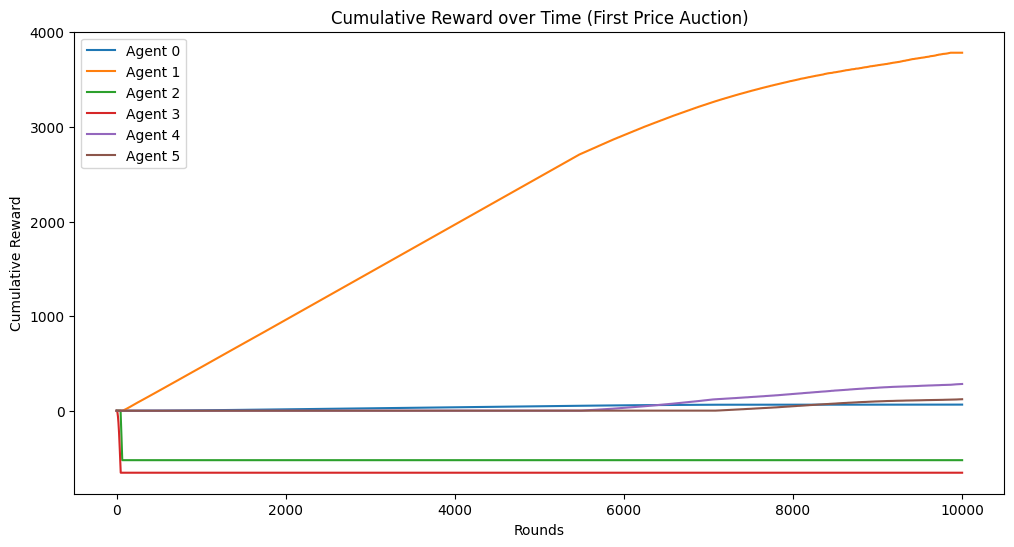

In [115]:
def run_simulation(n_advertisers, n_rounds, budget, base_valuation):
    ctrs = np.random.uniform(0.1, 1, n_advertisers)  # Random CTRs for each advertiser
    auction = FirstPriceAuction(ctrs)
    wins = [0 for i in range(n_advertisers)]
    
    agents = [
        MultiplicativePacingAgent(valuation=base_valuation, budget=budget, T=n_rounds, eta=0.1),
        MultiplicativePacingAgent(valuation=base_valuation, budget=budget, T=n_rounds, eta=0.1),
        UCBLikeAgent(budget=budget, T=n_rounds, bids=np.linspace(0, base_valuation, 100)),
        UCBLikeAgent(budget=budget, T=n_rounds, bids=np.linspace(0, base_valuation, 100)),
        EXP3AgentPrimalDual(possible_bids=np.linspace(0, base_valuation, 100), learning_rate=0.1, budget=budget, eta=0.1, T=n_rounds),
        EXP3AgentPrimalDual(possible_bids=np.linspace(0, base_valuation, 100), learning_rate=0.1, budget=budget, eta=0.1, T=n_rounds)
    ]
    
    rewards = {i: [] for i in range(n_advertisers)}
    cumulative_rewards = {i: [0] for i in range(n_advertisers)}

    for round in range(n_rounds):
        bids = [agent.bid() for agent in agents]
        
        winner, values = auction.get_winners(bids)
        payment = auction.get_payments_per_click(winner, values, bids)
        
        for i, agent in enumerate(agents):
            if i == winner:
                wins[i] += 1
                reward = ctrs[i] * (base_valuation - payment)
                agent.update(reward, payment)
                rewards[i].append(reward)
                cumulative_rewards[i].append(cumulative_rewards[i][-1] + reward)
            else:
                agent.update(0, 0)
                rewards[i].append(0)
                cumulative_rewards[i].append(cumulative_rewards[i][-1])

    return rewards, cumulative_rewards, wins

# Run the simulation
n_advertisers = 6
n_rounds = 10000
budget = 1000
base_valuation = 1

rewards, cumulative_rewards, wins = run_simulation(n_advertisers, n_rounds, budget, base_valuation)

# Plot results
plt.figure(figsize=(12, 6))
for i in range(len(cumulative_rewards)):
    plt.plot(cumulative_rewards[i], label=f'Agent {i}')

plt.title('Cumulative Reward over Time (First Price Auction)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.show()

In [116]:
# Print number of wins and cumulative utilities for each agent
print("Agent Results:")
print("Agent\tWins\tCumulative Utility")
print("-----\t----\t------------------")
for i in range(n_advertisers):
    print(f"{i}\t{wins[i]}\t{cumulative_rewards[i][-1]:.2f}")

# Print total wins
total_wins = sum(wins)
print(f"\nTotal wins: {total_wins}")

# Print win percentages
print("\nWin Percentages:")
for i in range(n_advertisers):
    win_percentage = (wins[i] / total_wins) * 100
    print(f"Agent {i}: {win_percentage:.2f}%")

Agent Results:
Agent	Wins	Cumulative Utility
-----	----	------------------
0	1211	64.88
1	6472	3784.76
2	19	-522.60
3	45	-655.25
4	1378	282.85
5	875	121.68

Total wins: 10000

Win Percentages:
Agent 0: 12.11%
Agent 1: 64.72%
Agent 2: 0.19%
Agent 3: 0.45%
Agent 4: 13.78%
Agent 5: 8.75%


In [117]:

# Group agents by algorithm type
algorithm_groups = {
    "MultiplicativePacingAgent": [0, 1],
    "UCBLikeAgent": [2, 3],
    "EXP3AgentPrimalDual": [4, 5]
}

# Calculate average performance for each algorithm
algorithm_performance = {}
for algo, agents in algorithm_groups.items():
    avg_utility = sum(cumulative_rewards[i][-1] for i in agents) / len(agents)
    avg_wins = sum(wins[i] for i in agents) / len(agents)
    avg_win_percentage = sum((wins[i] / total_wins) * 100 for i in agents) / len(agents)
    
    algorithm_performance[algo] = {
        "avg_utility": avg_utility,
        "avg_wins": avg_wins,
        "avg_win_percentage": avg_win_percentage
    }

# Determine the best algorithm based on average utility
best_algorithm = max(algorithm_performance, key=lambda x: algorithm_performance[x]["avg_utility"])

print("\nAlgorithm Performance:")
for algo, perf in algorithm_performance.items():
    print(f"{algo}:")
    print(f"  Average Utility: {perf['avg_utility']:.2f}")
    print(f"  Average Wins: {perf['avg_wins']:.2f}")
    print(f"  Average Win Percentage: {perf['avg_win_percentage']:.2f}%")

print(f"\nBest performing algorithm based on average utility: {best_algorithm}")


Algorithm Performance:
MultiplicativePacingAgent:
  Average Utility: 1924.82
  Average Wins: 3841.50
  Average Win Percentage: 38.41%
UCBLikeAgent:
  Average Utility: -588.92
  Average Wins: 32.00
  Average Win Percentage: 0.32%
EXP3AgentPrimalDual:
  Average Utility: 202.26
  Average Wins: 1126.50
  Average Win Percentage: 11.27%

Best performing algorithm based on average utility: MultiplicativePacingAgent
